### rozwiązanie problemu komiwojażera
## Algorytm Genetyczny
#### Komosa Maciej, Informatyka i Ekonometria, studia stacjonarne, 3 rok

Algorytm genetyczny polega na wygenerowaniu pewnego zbioru potencjalnych rozwiązań danego problemu, a następnie ocenienie rozwiązań daną funkcją dopasowania, wybraniu *osobników* o najlepszych wynikach oraz *krzyżowaniu* ich celem uzyskania nowych *pokoleń*, które będą osiągały lepsze wyniki od poprzednich. 

W tym projekcie:
- populacja początkowa generowana jest w sposób losowy
- funkcją dopasowania jest całkowita długość trasy
- są cztery metody wyboru najlepszych *osobników*:
    - turniejowa, w której *rodzice* porównywani są w parach
    - rankingowa prosta, ... wybierani są zgodnie z ich miejscem w rankingu 
    - rankingowa złożona, ... losowani są z prawdopodobieństwem zależnym od ich miejsca w rankingu
    - ruletkowa, ... prawdopodobieństwem równym *1/dopasowanie*
    - losowa, ... równym prawdopodobieństwem
- krzyżowanie przebiega zgodnie z jedną z dwóch metod:
    - OX: wylosowane zostają dwa *punkty przecięcia*, które dzielą *osobnika* na trzy części: środkowa przepisywana jest z rodzica pierwszego, a pierwsza i ostatnia z drugiego, przy czym w przypadku powtórzenia się którejś z liczb wybierana jest kolejna
    - autorska: pierwszy wyraz przepisywany jest z pierwszego rodzica, drugi z drugiego etc. jeśli wyraz się powtarza, brany jest kolejny
- istnieje prawdopodobieństwo mutacji, w której dwa elementy *osobnika* zamieniane są ze sobą miejscami

## importowanie podstawowych bibliotek

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from tqdm import tqdm

## wczytywanie i zapisywanie danych i generowanie początkowych kombinacji

In [3]:
# zwraca dane z pliku xlsx w postaci ndarray
def wczytajDaneXlsx(sciezkaPliku: str):
    dane = pd.read_excel(sciezkaPliku)
    dane.fillna(0, inplace=True)
    return dane.values

# zwraca ndarray wszystkich wyników populacji, [populacja][osobnik]
def archiwizujPopulacje(populacja: np.ndarray, wynikiPopulacji: np.ndarray, archiwum, iteracja):
    populacjaZWynikami = np.column_stack((populacja, wynikiPopulacji))
    archiwum[iteracja] = populacjaZWynikami
    return archiwum

# zwraca populacje początkową, ndarray n losowych permutacji punktów zawartych w danych
def generujPopulacjęPoczątkową(dane: np.ndarray, n):
    indeksy = list(range(len(dane)))
    populacja = np.zeros(n, dtype=np.ndarray)
    for i in range(n):
        populacja[i] = np.random.permutation(indeksy)
    return populacja

## obliczanie wyników wybranej populacji

In [4]:
# zwraca wyniki populacji, ndarray zawierający długości tras dla danego osobnika
def obliczWynikiPopulacji(dane: np.ndarray, populacja: np.ndarray):
    wynikiPopulacji = np.zeros(len(populacja), dtype=np.ndarray)
    for i in range(len(populacja)):
        wynikiPopulacji[i] = (obliczOdleglosc(dane, populacja[i]))
    return wynikiPopulacji

# zwraca odległość trasy danego osobnika
def obliczOdleglosc(dane: np.ndarray, osobnik):
    odleglosc = 0
    for i in range(len(osobnik)-1):
        odleglosc += dane[int(osobnik[i])][int(osobnik[i+1])]
    odleglosc += dane[int(osobnik[-1])][int(osobnik[0])]
    return odleglosc

# zwraca listę n% najlepszych wyników
def obliczProcentNajlepszych(wynikiPopulacji: np.ndarray, procent):
    wynikiPopulacji = np.argsort(wynikiPopulacji)
    wynikiPopulacji = wynikiPopulacji[:int(len(wynikiPopulacji)*procent)]
    return wynikiPopulacji

## wybieranie rodziców

In [5]:
# zwraca listę najlepszych rodziców
def wybierzNajlepszychRodziców(dane: np.ndarray, populacja: np.ndarray, metoda = 'turniejowa', n = 2):
    wynikiPopulacji = obliczWynikiPopulacji(dane, populacja)

    if metoda == 'turniejowa':
        rodzice = wybierzNajlepszychRodzicówMetodąTurniejową(populacja, wynikiPopulacji, n)
    elif metoda == 'rankingowa prosta' or metoda == 'rankingowa':
        rodzice = wybierzNajlepszychRodzicówMetodąRankingowąProstą(populacja, wynikiPopulacji, n)
    elif metoda == 'rankingowa złożona':
        rodzice = wybierzNajlepszychRodzicówMetodąRankingowąZłożoną(populacja, wynikiPopulacji, n)
    elif metoda == 'ruletkowa':
        rodzice = wybierzNajlepszychRodzicówMetodąRuletkową(populacja, wynikiPopulacji, n)
    elif metoda == 'losowa':
        rodzice = wybierzNajlepszychRodzicówMetodąLosową(populacja, n)
    else:
        raise Exception('Nieznana metoda selekcji')
    return rodzice

# zwraca listę 1/n najlepszych osobników z populacji
def wybierzNajlepszychRodzicówMetodąTurniejową(populacja: np.ndarray, wynikiPopulacji: np.ndarray, n = 2):
    rodzice = np.zeros(len(populacja) // n, dtype=np.ndarray)
    
    sorted_indices = np.argsort(wynikiPopulacji)
    populacja = populacja[sorted_indices]
    wynikiPopulacji = wynikiPopulacji[sorted_indices]
    
    for i in range(len(rodzice)):
        if wynikiPopulacji[2*i] < wynikiPopulacji[(2*i + 1) % (len(populacja))]:
            rodzice[i] = populacja[2*i]
        else:
            rodzice[i] = populacja[(2*i + 1) % (len(populacja))]
    return rodzice

# zwraca listę 1/n najlepszych osobników z populacji
def wybierzNajlepszychRodzicówMetodąRankingowąProstą(populacja: np.ndarray, wynikiPopulacji: np.ndarray, n = 2):
    rodzice = np.zeros(len(populacja) // n, dtype=np.ndarray)

    sorted_indices = np.argsort(wynikiPopulacji)
    populacja = populacja[sorted_indices]
    wynikiPopulacji = wynikiPopulacji[sorted_indices]

    for i in range(int(len(populacja) // n)):
        rodzice[i] = populacja[i]
    return rodzice

# zwraca listę 1/n najlepszych osobników z populacji
def wybierzNajlepszychRodzicówMetodąRankingowąZłożoną(populacja: np.ndarray, wynikiPopulacji: np.ndarray, n = 2):
    rodzice = np.zeros(len(populacja) // n, dtype=np.ndarray)
    prawdopodobienstwa = np.zeros(len(populacja))

    sorted_indices = np.argsort(wynikiPopulacji)
    populacja = populacja[sorted_indices]
    wynikiPopulacji = wynikiPopulacji[sorted_indices]

    for i in range(len(populacja)):
        prawdopodobienstwa[i] = (1 / (i + 1))

    prawdopodobienstwa = prawdopodobienstwa / prawdopodobienstwa.sum()

    for i in range(int(len(populacja) // n)):
        rodzice[i] = np.random.choice(populacja, p=prawdopodobienstwa)
    return rodzice

# zwraca listę 1/n najlepszych osobników z populacji
def wybierzNajlepszychRodzicówMetodąRuletkową(populacja: np.ndarray, wynikiPopulacji: np.ndarray, n = 2):
    rodzice = np.zeros(len(populacja) // n, dtype=np.ndarray)
    prawdopodobienstwa = np.zeros(len(populacja))
    
    sorted_indices = np.argsort(wynikiPopulacji)
    populacja = populacja[sorted_indices]
    wynikiPopulacji = wynikiPopulacji[sorted_indices]

    for i in range(len(populacja)):
        prawdopodobienstwa[i] = (1 / wynikiPopulacji[i])
    prawdopodobienstwa = prawdopodobienstwa / prawdopodobienstwa.sum()
    for i in range(int(len(populacja) // n)):
        rodzice[i] = np.random.choice(populacja, p=prawdopodobienstwa)
    return rodzice

# zwraca listę 1/n losowych osobników z populacji
def wybierzNajlepszychRodzicówMetodąLosową(populacja: np.ndarray, n = 2):
    rodzice = np.zeros(len(populacja) // n, dtype=np.ndarray)
    for i in range(len(populacja) // n):
        rodzice[i] = np.random.choice(populacja)
    return rodzice


## krzyżowanie

In [6]:
# przyjmuje rodziców, paruje ich i zwraca dzieci
def krzyżuj(rodzice, metoda = 'OX'):
    rodziceWParach = paruj(rodzice)
    potomstwoWParach = np.zeros_like(rodziceWParach)
    if metoda == 'OX':
        krzyżujParę = krzyżujParęMetodąOX
    elif metoda == 'autorska':
        krzyżujParę = krzyżujParęMetodąAutorską
    else:
        raise Exception('Nieznana metoda krzyżowania!')
    
    for i in range(len(rodziceWParach)):
        potomstwoWParach[i] = krzyżujParę(rodziceWParach[i])

    potomstwo = np.zeros(len(rodziceWParach) * 2, dtype=np.ndarray)
    for i in range(len(potomstwoWParach)):
        potomstwo[2*i] = np.array(potomstwoWParach[i][0], dtype=int)
        potomstwo[2*i + 1] = np.array(potomstwoWParach[i][1], dtype=int)
    
    return potomstwo

# łączy rodziców w pary i zwraca listę par 
def paruj(rodzice: np.ndarray):
    rodzice_w_parach = np.zeros(len(rodzice), dtype=np.ndarray)

    for i in range(0, rodzice.shape[0] - 1):
        pair = np.array([rodzice[i], rodzice[i + 1]])
        rodzice_w_parach[i] = pair

    pair = np.array([rodzice[-1], rodzice[0]])
    rodzice_w_parach[-1] = pair

    return np.array(rodzice_w_parach)

# krzyżuje parę rodziców metodą OX, zwraca parę dzieci
def krzyżujParęMetodąOX(rodzice: np.ndarray):
    assert len(rodzice) == 2
    potomstwo = np.full(rodzice.shape, np.nan)
    punkty_przekroju = np.random.choice(range(1, len(rodzice[0]) - 1), 2, replace=False)
    punkty_przekroju.sort()
   
    for i in range(len(potomstwo)):
        potomstwo[i, punkty_przekroju[0]:punkty_przekroju[1]] = rodzice[i, punkty_przekroju[0]:punkty_przekroju[1]]
        for j in chain(range(punkty_przekroju[0]), range(punkty_przekroju[1], len(potomstwo[i]))):
            if potomstwo[i, j] == np.nan:
                potomstwo[i, j] = rodzice[(i+1)%2, j]
            else:
                k = 0 
                while rodzice[(i+2)%2, k] in potomstwo[i]:
                    k += 1
                potomstwo[i, j] = rodzice[(i+2)%2, k]
    
    return potomstwo

def krzyżujParęMetodąAutorską(rodzice):
    assert len(rodzice) == 2
    potomstwo = np.full(rodzice.shape, np.nan)
    for i in range(len(potomstwo)):
        for j in range(len(potomstwo[i])):
            k = j
            while rodzice[(j+1)%2, k] in potomstwo[i]:
                if len(set(potomstwo[i])) == len(potomstwo[i]):
                    break
                k += 1
                
            potomstwo[i, j] = rodzice[(i+1)%2, k]
                
    return potomstwo

## mutacja

In [7]:
def mutuj(populacja: np.ndarray, prawdopodobienstwoMutacji = 0.1):
    for i in range(len(populacja)):
        if np.random.random() < prawdopodobienstwoMutacji:
            indices = np.random.choice(range(len(populacja[i])), 2, replace=False)
            populacja[i][indices[0]], populacja[i][indices[1]] = populacja[i][indices[1]], populacja[i][indices[0]]
    return populacja

## pełen przebieg algorytmu

In [8]:
def algorytm_genetyczny(dane, n=25, iteracje=100, metodaSelekcji='turniejowa',
                        metodaKrzyzowania='OX', prawdopodobienstwoMutacji=0.1):
    populacja = generujPopulacjęPoczątkową(dane, n)
    wynikiPopulacji = obliczWynikiPopulacji(dane, populacja)
    archiwum = np.zeros(iteracje, dtype=np.ndarray)
    archiwum = archiwizujPopulacje(populacja, wynikiPopulacji, archiwum, 0)
    for i in tqdm(range(0, iteracje)):
        rodzice = wybierzNajlepszychRodziców(dane=dane, populacja=populacja, metoda=metodaSelekcji)
        populacja = krzyżuj(rodzice=rodzice, metoda=metodaKrzyzowania)
        populacja = mutuj(populacja=populacja, prawdopodobienstwoMutacji=prawdopodobienstwoMutacji)
        wynikiPopulacji = obliczWynikiPopulacji(dane=dane, populacja=populacja)
        archiwum = archiwizujPopulacje(populacja=populacja, wynikiPopulacji=wynikiPopulacji,
                                        archiwum=archiwum, iteracja=i)
    
    najlepszy_wynik = None
    tabela_iteracji = pd.DataFrame()
    for i in range(len(archiwum)):
        archiwum[i] = archiwum[i][archiwum[i][:, -1].argsort()]
        tabela_iteracji[i] = archiwum[i][0]
        if najlepszy_wynik is None or archiwum[i][0][-1] < najlepszy_wynik[-1]:
            najlepszy_wynik = archiwum[i][0]
    return najlepszy_wynik, tabela_iteracji


## część obliczeniowa - sprawdzanie wydajności algorytmu

### TSP_48

importowanie danych

In [55]:
dane = wczytajDaneXlsx('Dane_TSP_48.xlsx')

#### porównywanie wydajności algorytmu biorąc pod uwagę wielkość populacji początkowej
przy 1000 iteracji, rankingowej metodzie selekcji, autorskiej metodzie krzyżowania oraz prawdopodobienstwie mutacji 0.1

dla n równego  20


100%|██████████| 1000/1000 [00:02<00:00, 439.55it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  100


100%|██████████| 1000/1000 [00:11<00:00, 90.40it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  250


100%|██████████| 1000/1000 [00:27<00:00, 36.43it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  500


100%|██████████| 1000/1000 [00:54<00:00, 18.21it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  1000


100%|██████████| 1000/1000 [01:50<00:00,  9.08it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


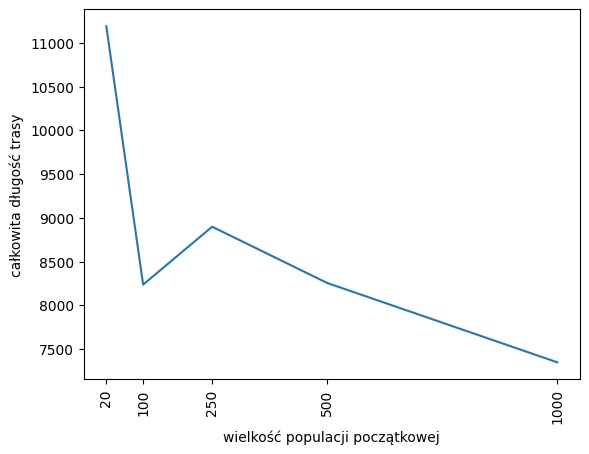

In [56]:
x = []
y = []
for n in [20, 100, 250, 500, 1000]:
    print('dla n równego ', n)
    wynik, _ = algorytm_genetyczny(dane=dane, n=n, iteracje=1000, metodaSelekcji='rankingowa', metodaKrzyzowania='autorska')
    x.append(n)
    y.append(wynik[-1])

najlepsze_n = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('wielkość populacji początkowej')
plt.ylabel('całkowita długość trasy')
plt.xticks(x, rotation='vertical')
plt.plot(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę liczbę iteracji
przy wielkości początkowej populacji równej 250, rankingowej metodzie selekcji, autorskiej metodzie krzyżowania oraz prawdopodobienstwie mutacji 0.1

dla i równego  100


100%|██████████| 100/100 [00:02<00:00, 35.05it/s]


dla i równego  500


100%|██████████| 500/500 [00:13<00:00, 36.20it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla i równego  1000


100%|██████████| 1000/1000 [00:27<00:00, 36.22it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla i równego  2500


100%|██████████| 2500/2500 [01:09<00:00, 36.01it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla i równego  10000


100%|██████████| 10000/10000 [04:38<00:00, 35.93it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


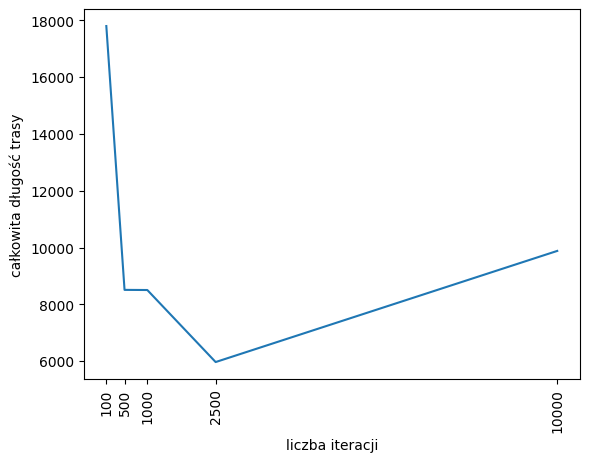

In [57]:
x = []
y = []
for i in [100, 500, 1000, 2500, 10000]:
    print('dla i równego ', i)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=i, metodaSelekcji='rankingowa', metodaKrzyzowania='autorska')
    x.append(i)
    y.append(wynik[-1])

najlepsze_i = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('liczba iteracji')
plt.ylabel('całkowita długość trasy')
plt.xticks(x, rotation='vertical')
plt.plot(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę metodę selekcji
przy wielkości początkowej populacji równej 250, 1000 iteracji, autorskiej metodzie krzyżowania oraz prawdopodobienstwie mutacji 0.1

dla metodySelekcji  turniejowa


100%|██████████| 1000/1000 [00:41<00:00, 24.07it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  rankingowa prosta


100%|██████████| 1000/1000 [00:27<00:00, 37.02it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  rankingowa złożona


100%|██████████| 1000/1000 [00:28<00:00, 34.73it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  ruletkowa


100%|██████████| 1000/1000 [00:33<00:00, 30.29it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  losowa


100%|██████████| 1000/1000 [00:37<00:00, 26.68it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


<BarContainer object of 5 artists>

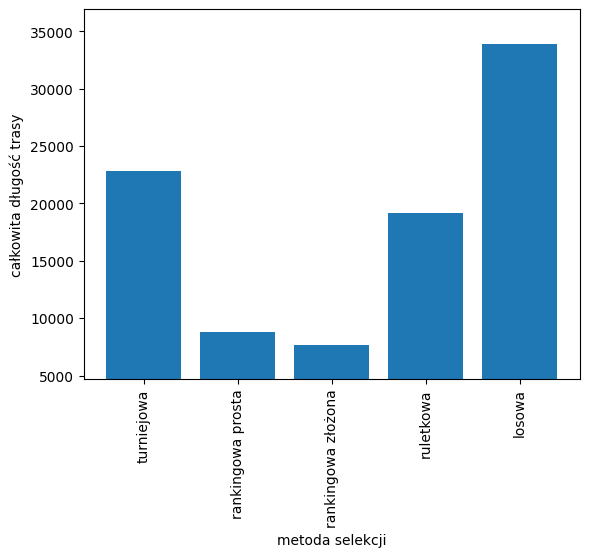

In [58]:
x = []
y = []
for metodaSelekcji in ['turniejowa', 'rankingowa prosta', 'rankingowa złożona', 'ruletkowa', 'losowa']:
    print('dla metodySelekcji ', metodaSelekcji)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=1000, metodaSelekcji=metodaSelekcji, metodaKrzyzowania='autorska')
    x.append(metodaSelekcji)
    y.append(wynik[-1])

najlepsza_metoda_selekcji = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('metoda selekcji')
plt.ylabel('całkowita długość trasy')
plt.ylim(min(y)-3000, max(y)+3000)
plt.xticks(rotation='vertical')
plt.bar(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę metodę krzyżowania
przy wielkości początkowej populacji równej 250, 1000 iteracji, rankingowej metodzie selekcji oraz prawdopodobienstwie mutacji 0.1

dla metodyKrzyżowania  OX


100%|██████████| 1000/1000 [12:17<00:00,  1.36it/s]  
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodyKrzyżowania  autorska


100%|██████████| 1000/1000 [00:27<00:00, 36.75it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


<BarContainer object of 2 artists>

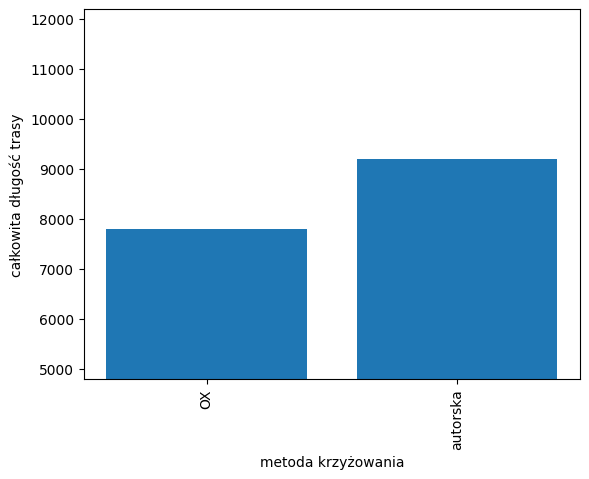

In [59]:
x = []
y = []
for metodaKrzyżowania in ['OX', 'autorska']:
    print('dla metodyKrzyżowania ', metodaKrzyżowania)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=1000, metodaSelekcji='rankingowa', metodaKrzyzowania=metodaKrzyżowania)
    x.append(metodaKrzyżowania)
    y.append(wynik[-1])

najlepsza_metoda_krzyżowania = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('metoda krzyżowania')
plt.ylabel('całkowita długość trasy')
plt.ylim(min(y)-3000, max(y)+3000)
plt.xticks(rotation='vertical')
plt.bar(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę prawdopodobieństwo mutacji
przy wielkości początkowej populacji równej 250, 1000 iteracji, rankingowej metodzie selekcji oraz autorskiej metodzie krzyżowania

dla pm równego  0


100%|██████████| 1000/1000 [00:26<00:00, 37.80it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.1


100%|██████████| 1000/1000 [00:26<00:00, 37.30it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.2


100%|██████████| 1000/1000 [00:27<00:00, 36.99it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.5


100%|██████████| 1000/1000 [00:29<00:00, 34.00it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.8


100%|██████████| 1000/1000 [00:38<00:00, 25.66it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  1


100%|██████████| 1000/1000 [00:42<00:00, 23.58it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


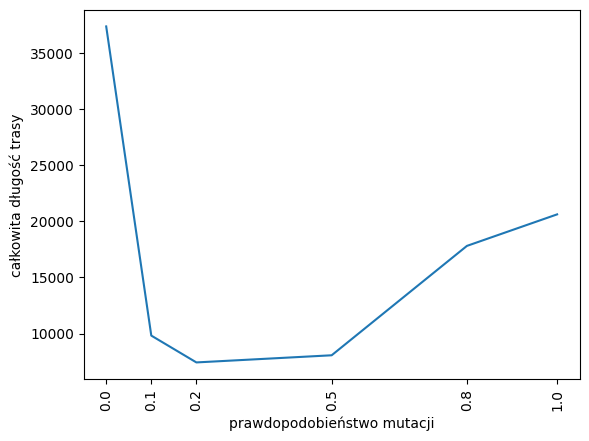

In [60]:
x = []
y = []
for pm in [0, 0.1, 0.2, 0.5, 0.8, 1]:
    print('dla pm równego ', pm)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=1000, metodaSelekcji='rankingowa', metodaKrzyzowania='autorska', prawdopodobienstwoMutacji=pm)
    x.append(pm)
    y.append(wynik[-1])

najlepsze_pm = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('prawdopodobieństwo mutacji')
plt.ylabel('całkowita długość trasy')
plt.xticks(x, rotation='vertical')
plt.plot(x, y)

#### próba znalezienia optymalnego rozwiązania
dla najlepszych wartości parametrów

In [61]:
wynik, _ = algorytm_genetyczny(dane=dane, n=najlepsze_n, iteracje=najlepsze_i, metodaSelekcji=najlepsza_metoda_selekcji, metodaKrzyzowania=najlepsza_metoda_krzyżowania, prawdopodobienstwoMutacji=najlepsze_pm)
print("najlepsza droga: ", wynik[0], ", długość: ", wynik[-1])

100%|██████████| 2500/2500 [49:55<00:00,  1.20s/it]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


najlepsza droga:  [39 40 34 43  9 10 11 35 36  7  8 41 42  6  0  1 21 46  4 27 28 19 20 33
 44 14 15 16 30 31 37 38 22 23 24 25 26  5 17 18 32  2  3 12 13 29 45] , długość:  8917


### TSP_76

importowanie danych

In [9]:
dane = wczytajDaneXlsx('Dane_TSP_76.xlsx')

#### porównywanie wydajności algorytmu biorąc pod uwagę wielkość populacji początkowej
przy 1000 iteracji, rankingowej metodzie selekcji, autorskiej metodzie krzyżowania oraz prawdopodobienstwie mutacji 0.1

dla n równego  20


100%|██████████| 1000/1000 [00:03<00:00, 280.50it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  100


100%|██████████| 1000/1000 [01:57<00:00,  8.50it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  250


100%|██████████| 1000/1000 [00:42<00:00, 23.57it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  500


100%|██████████| 1000/1000 [01:25<00:00, 11.74it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  1000


100%|██████████| 1000/1000 [02:50<00:00,  5.85it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


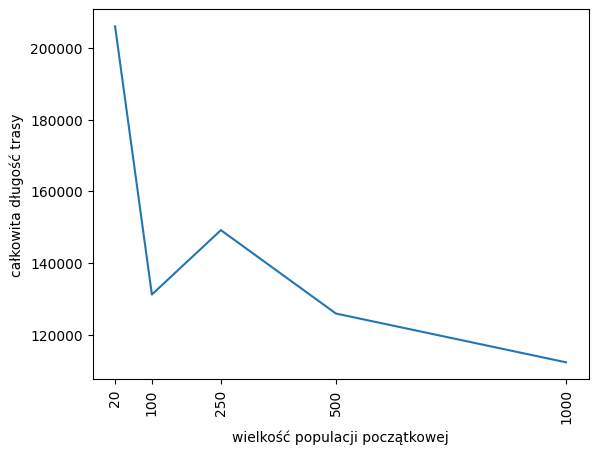

In [63]:
x = []
y = []
for n in [20, 100, 250, 500, 1000]:
    print('dla n równego ', n)
    wynik, _ = algorytm_genetyczny(dane=dane, n=n, iteracje=1000, metodaSelekcji='rankingowa', metodaKrzyzowania='autorska')
    x.append(n)
    y.append(wynik[-1])

najlepsze_n = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('wielkość populacji początkowej')
plt.ylabel('całkowita długość trasy')
plt.xticks(x, rotation='vertical')
plt.plot(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę liczbę iteracji
przy wielkości początkowej populacji równej 250, rankingowej metodzie selekcji, autorskiej metodzie krzyżowania oraz prawdopodobienstwie mutacji 0.1

dla i równego  100


100%|██████████| 100/100 [00:04<00:00, 21.43it/s]


dla i równego  500


100%|██████████| 500/500 [00:22<00:00, 22.59it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla i równego  1000


100%|██████████| 1000/1000 [00:43<00:00, 23.21it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla i równego  2500


100%|██████████| 2500/2500 [01:50<00:00, 22.68it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla i równego  10000


100%|██████████| 10000/10000 [07:07<00:00, 23.40it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


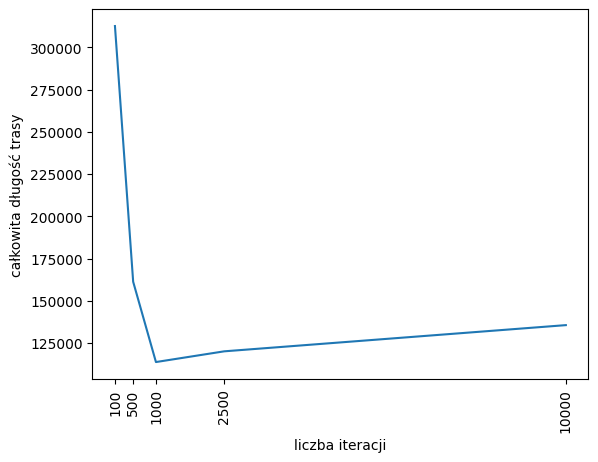

In [64]:
x = []
y = []
for i in [100, 500, 1000, 2500, 10000]:
    print('dla i równego ', i)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=i, metodaSelekcji='rankingowa', metodaKrzyzowania='autorska')
    x.append(i)
    y.append(wynik[-1])

najlepsze_i = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('liczba iteracji')
plt.ylabel('całkowita długość trasy')
plt.xticks(x, rotation='vertical')
plt.plot(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę metodę selekcji
przy wielkości początkowej populacji równej 250, 1000 iteracji, autorskiej metodzie krzyżowania oraz prawdopodobienstwie mutacji 0.1

dla metodySelekcji  turniejowa


100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  rankingowa prosta


100%|██████████| 1000/1000 [00:42<00:00, 23.47it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  rankingowa złożona


100%|██████████| 1000/1000 [00:43<00:00, 22.85it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  ruletkowa


100%|██████████| 1000/1000 [00:58<00:00, 17.17it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  losowa


100%|██████████| 1000/1000 [01:02<00:00, 15.98it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


<BarContainer object of 5 artists>

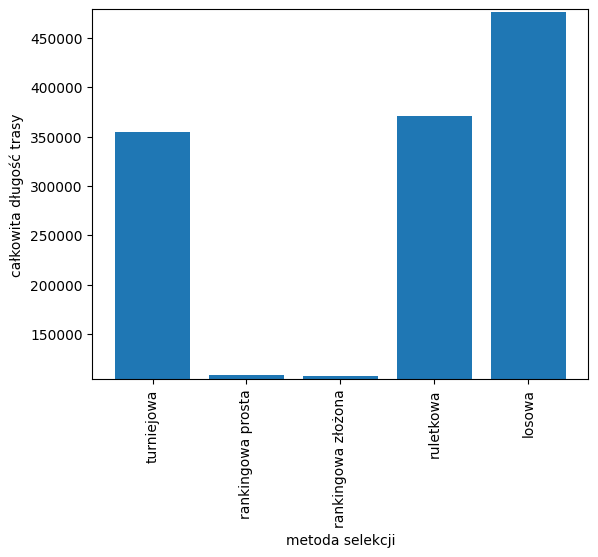

In [65]:
x = []
y = []
for metodaSelekcji in ['turniejowa', 'rankingowa prosta', 'rankingowa złożona', 'ruletkowa', 'losowa']:
    print('dla metodySelekcji ', metodaSelekcji)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=1000, metodaSelekcji=metodaSelekcji, metodaKrzyzowania='autorska')
    x.append(metodaSelekcji)
    y.append(wynik[-1])

najlepsza_metoda_selekcji = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('metoda selekcji')
plt.ylabel('całkowita długość trasy')
plt.ylim(min(y)-3000, max(y)+3000)
plt.xticks(rotation='vertical')
plt.bar(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę metodę krzyżowania
przy wielkości początkowej populacji równej 250, 1000 iteracji, rankingowej metodzie selekcji oraz prawdopodobienstwie mutacji 0.1

dla metodyKrzyżowania  OX


100%|██████████| 1000/1000 [11:56<00:00,  1.40it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_6199/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodyKrzyżowania  autorska


100%|██████████| 1000/1000 [00:43<00:00, 23.01it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_6199/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


<BarContainer object of 2 artists>

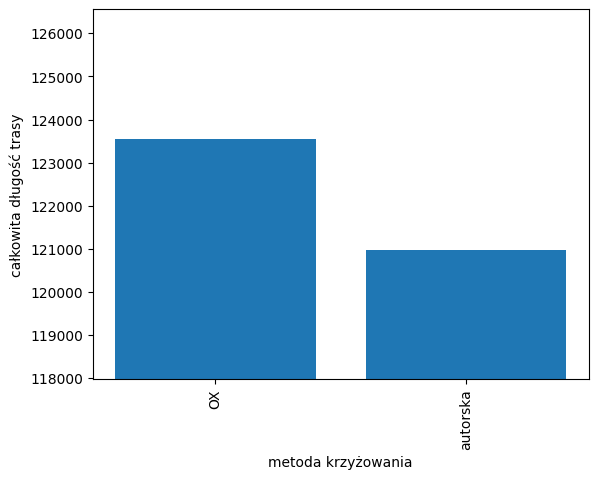

In [10]:
x = []
y = []
for metodaKrzyżowania in ['OX', 'autorska']:
    print('dla metodyKrzyżowania ', metodaKrzyżowania)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=1000, metodaSelekcji='rankingowa', metodaKrzyzowania=metodaKrzyżowania)
    x.append(metodaKrzyżowania)
    y.append(wynik[-1])

najlepsza_metoda_krzyżowania = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('metoda krzyżowania')
plt.ylabel('całkowita długość trasy')
plt.ylim(min(y)-3000, max(y)+3000)
plt.xticks(rotation='vertical')
plt.bar(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę prawdopodobieństwo mutacji
przy wielkości początkowej populacji równej 250, 1000 iteracji, rankingowej metodzie selekcji oraz autorskiej metodzie krzyżowania

dla pm równego  0


100%|██████████| 1000/1000 [00:43<00:00, 23.21it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_6199/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.1


100%|██████████| 1000/1000 [00:43<00:00, 23.07it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_6199/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.2


100%|██████████| 1000/1000 [00:43<00:00, 22.96it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_6199/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.5


100%|██████████| 1000/1000 [00:47<00:00, 21.04it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_6199/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.8


100%|██████████| 1000/1000 [01:15<00:00, 13.32it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_6199/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  1


100%|██████████| 1000/1000 [01:20<00:00, 12.44it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_6199/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


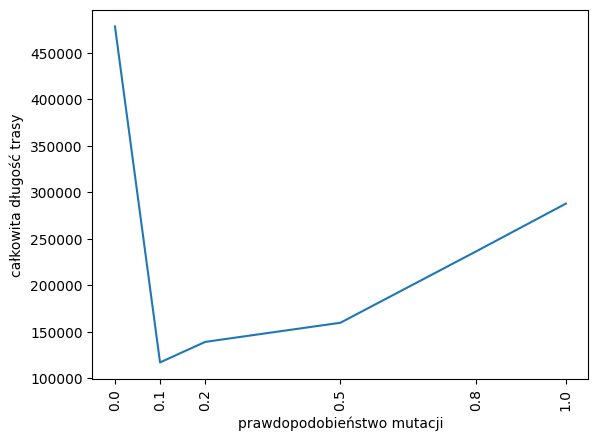

In [11]:
x = []
y = []
for pm in [0, 0.1, 0.2, 0.5, 0.8, 1]:
    print('dla pm równego ', pm)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=1000, metodaSelekcji='rankingowa', metodaKrzyzowania='autorska', prawdopodobienstwoMutacji=pm)
    x.append(pm)
    y.append(wynik[-1])

najlepsze_pm = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('prawdopodobieństwo mutacji')
plt.ylabel('całkowita długość trasy')
plt.xticks(x, rotation='vertical')
plt.plot(x, y)

#### próba znalezienia optymalnego rozwiązania
dla najlepszych wartości parametrów

In [15]:
wynik, _ = algorytm_genetyczny(dane=dane, n=najlepsze_n, iteracje=najlepsze_i, metodaSelekcji=najlepsza_metoda_selekcji, metodaKrzyzowania=najlepsza_metoda_krzyżowania, prawdopodobienstwoMutacji=najlepsze_pm)
print("najlepsza droga: ", wynik[0], ", długość: ", wynik[-1])

100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_6199/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


najlepsza droga:  [45 46 32 33 35 36 37 40 68 69 70 63 43 44 23 24 47 48 49 60 61 62 56 57
 58 59 71 72 13 14 15 17 18  4 19 21 22 53 54 55 38 39 27 28 20  0  2  3
 29 64 65 66 67 50 51 52 41 34 16  9 10 11 12 73 74  1  5  6  7  8 30 31
 25 26 42] , długość:  120413.97350401967


### TSP_127

importowanie danych

In [17]:
dane = wczytajDaneXlsx('Dane_TSP_127.xlsx')

#### porównywanie wydajności algorytmu biorąc pod uwagę wielkość populacji początkowej
przy 5000 iteracji, rankingowej metodzie selekcji, autorskiej metodzie krzyżowania oraz prawdopodobienstwie mutacji 0.1

dla n równego  20


100%|██████████| 5000/5000 [00:28<00:00, 174.56it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  100


100%|██████████| 5000/5000 [02:23<00:00, 34.82it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  250


100%|██████████| 5000/5000 [06:03<00:00, 13.77it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  500


100%|██████████| 5000/5000 [12:12<00:00,  6.83it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla n równego  1000


100%|██████████| 5000/5000 [24:20<00:00,  3.42it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


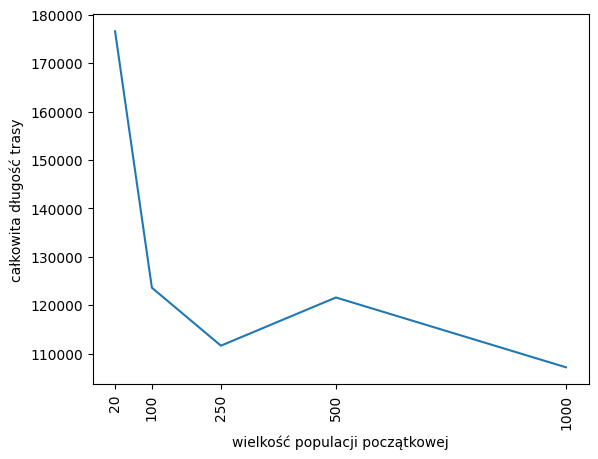

In [45]:
x = []
y = []
for n in [20, 100, 250, 500, 1000]:
    print('dla n równego ', n)
    wynik, _ = algorytm_genetyczny(dane=dane, n=n, iteracje=5000, metodaSelekcji='rankingowa', metodaKrzyzowania='autorska')
    x.append(n)
    y.append(wynik[-1])

najlepsze_n = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('wielkość populacji początkowej')
plt.ylabel('całkowita długość trasy')
plt.xticks(x, rotation='vertical')
plt.plot(x, y)


#### porównywanie wydajności algorytmu biorąc pod uwagę liczbę iteracji
przy wielkości początkowej populacji równej 250, rankingowej metodzie selekcji, autorskiej metodzie krzyżowania oraz prawdopodobienstwie mutacji 0.1

dla i równego  100


100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


dla i równego  500


100%|██████████| 500/500 [00:37<00:00, 13.38it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla i równego  1000


100%|██████████| 1000/1000 [01:13<00:00, 13.70it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla i równego  2500


100%|██████████| 2500/2500 [03:02<00:00, 13.72it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla i równego  10000


100%|██████████| 10000/10000 [12:07<00:00, 13.75it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


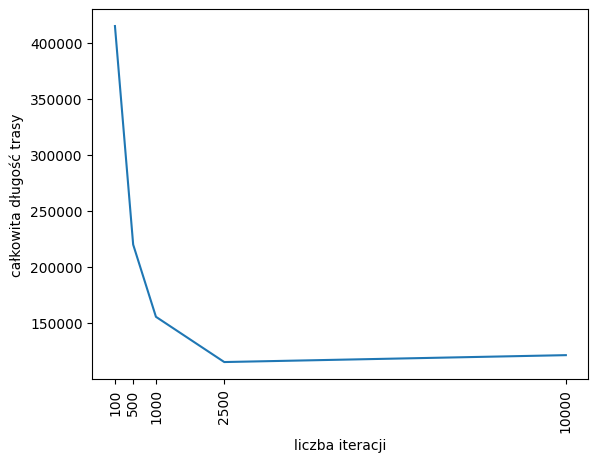

In [46]:
x = []
y = []
for i in [100, 500, 1000, 2500, 10000]:
    print('dla i równego ', i)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=i, metodaSelekcji='rankingowa', metodaKrzyzowania='autorska')
    x.append(i)
    y.append(wynik[-1])

najlepsze_i = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('liczba iteracji')
plt.ylabel('całkowita długość trasy')
plt.xticks(x, rotation='vertical')
plt.plot(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę metodę selekcji
przy wielkości początkowej populacji równej 250, 1000 iteracji, autorskiej metodzie krzyżowania oraz prawdopodobienstwie mutacji 0.1

dla metodySelekcji  turniejowa


100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  rankingowa prosta


100%|██████████| 1000/1000 [01:13<00:00, 13.69it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  rankingowa złożona


100%|██████████| 1000/1000 [01:14<00:00, 13.49it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  ruletkowa


100%|██████████| 1000/1000 [01:51<00:00,  8.99it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodySelekcji  losowa


100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


<BarContainer object of 5 artists>

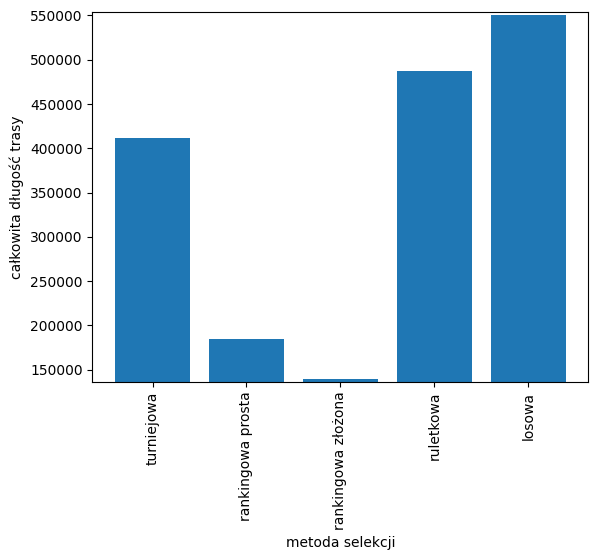

In [48]:
x = []
y = []
for metodaSelekcji in ['turniejowa', 'rankingowa prosta', 'rankingowa złożona', 'ruletkowa', 'losowa']:
    print('dla metodySelekcji ', metodaSelekcji)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=1000, metodaSelekcji=metodaSelekcji, metodaKrzyzowania='autorska')
    x.append(metodaSelekcji)
    y.append(wynik[-1])

najlepsza_metoda_selekcji = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('metoda selekcji')
plt.ylabel('całkowita długość trasy')
plt.ylim(min(y)-3000, max(y)+3000)
plt.xticks(rotation='vertical')
plt.bar(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę metodę krzyżowania
przy wielkości początkowej populacji równej 250, 1000 iteracji, rankingowej metodzie selekcji oraz prawdopodobienstwie mutacji 0.1

dla metodyKrzyżowania  OX


100%|██████████| 1000/1000 [34:08<00:00,  2.05s/it]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla metodyKrzyżowania  autorska


100%|██████████| 1000/1000 [01:14<00:00, 13.49it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


<BarContainer object of 2 artists>

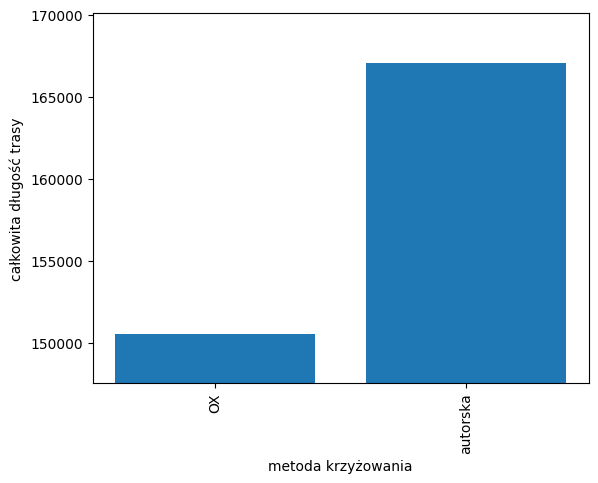

In [49]:
x = []
y = []
for metodaKrzyżowania in ['OX', 'autorska']:
    print('dla metodyKrzyżowania ', metodaKrzyżowania)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=1000, metodaSelekcji='rankingowa', metodaKrzyzowania=metodaKrzyżowania)
    x.append(metodaKrzyżowania)
    y.append(wynik[-1])

najlepsza_metoda_krzyżowania = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('metoda krzyżowania')
plt.ylabel('całkowita długość trasy')
plt.ylim(min(y)-3000, max(y)+3000)
plt.xticks(rotation='vertical')
plt.bar(x, y)

#### porównywanie wydajności algorytmu biorąc pod uwagę prawdopodobieństwo mutacji
przy wielkości początkowej populacji równej 250, 1000 iteracji, rankingowej metodzie selekcji oraz autorskiej metodzie krzyżowania

dla pm równego  0.1


100%|██████████| 1000/1000 [01:14<00:00, 13.48it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.2


100%|██████████| 1000/1000 [01:14<00:00, 13.38it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.5


100%|██████████| 1000/1000 [01:28<00:00, 11.27it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


dla pm równego  0.8


100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_3791/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


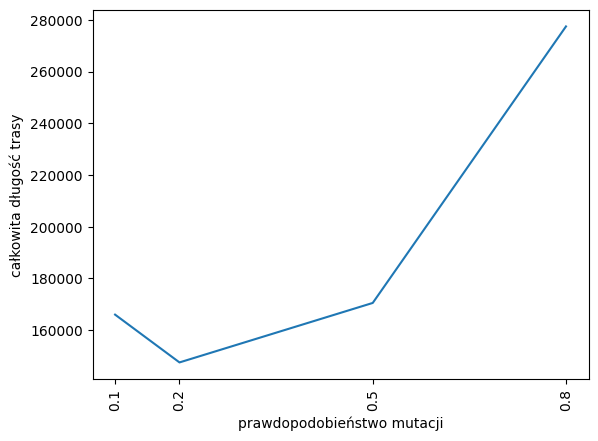

In [50]:
x = []
y = []
for pm in [0.1, 0.2, 0.5, 0.8]:
    print('dla pm równego ', pm)
    wynik, _ = algorytm_genetyczny(dane=dane, n=250, iteracje=1000, metodaSelekcji='rankingowa', metodaKrzyzowania='autorska', prawdopodobienstwoMutacji=pm)
    x.append(pm)
    y.append(wynik[-1])

najlepsze_pm = min(zip(x, y), key=lambda pair: pair[1])[0]

plt.xlabel('prawdopodobieństwo mutacji')
plt.ylabel('całkowita długość trasy')
plt.xticks(x, rotation='vertical')
plt.plot(x, y)

#### próba znalezienia optymalnego rozwiązania
dla najlepszych wartości parametrów

In [21]:
wynik, _ = algorytm_genetyczny(dane=dane, n=najlepsze_n, iteracje=najlepsze_i, metodaSelekcji=najlepsza_metoda_selekcji, metodaKrzyzowania=najlepsza_metoda_krzyżowania, prawdopodobienstwoMutacji=najlepsze_pm)
print("najlepsza droga: ", wynik[0], ", długość: ", wynik[-1])

100%|██████████| 2500/2500 [12:18<00:00,  3.39it/s]
/var/folders/12/1hgps4j93ws6w61h6p6yr39m0000gn/T/ipykernel_6199/1851740351.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tabela_iteracji[i] = archiwum[i][0]


najlepsza droga:  [ 26 121  27  67  68  70  23  32  33   0  34  42  56  99 100 101  43 102
 103  14  15  20  21  89  60 115 125 122   4   5   6  66  95  96  97  64
  65  72  17  22 119  50 120  31  24  25  19   3  55  53  54 123  91  92
  45  48   9   7  10  36  37  38  39  35  13  79  80  81 116  52  44  93
  94  61  62 112 104 105 106 113  49   1   2  71  69 108  98  12  40  41
  29  83  84  85  86 109 110 117 118   8  63  51  46  47 111  73  74  75
 107  87  88  18  16  76  77  78  30  28  11 114  57  58  59  90 124  82] , długość:  112301.91309099618


# Omówienie wyników
Niezależnie od zbioru danych, większe wartości okazywały się korzystne dla wyników działania algorytmu dla parametrów wielkości populacji początkowej oraz liczby iteracji.
Najlepsze noty uzyskiwały algorytmy rankingowe, ze złożonym na czele.
Z metod krzyżowania w dwóch przypadkach lepszym okazał sie OX, a gorszym - autorski, z tym jednak, że czas potrzebny na przeprowadzenie obliczeń był kilkukrotnie mniejszy w przypadku tego drugiego, co jednoznacznie go nie dyskwalifikuje.
Prawdopodobieństwo mutacji osiągnęło optimum w punkcie 0.2 dla dwóch algorytmów oraz 0.1 dla jednego. Dla zestawów danych, dla których badany był wpływ zerowego prawdopodobieństwa mutacji, osiągnęło ono najniższy ze wszystkich wynik, co oznacza, że mutacja powinna zachodzić aby algorytm był efektywny, jednak jej prawdopodobieństwo nie może być zbyt duże.